<h1>C4 Solution</h1>

<h3>Install and import</h3>

In [1]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [1]:
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


<h3>Get the data and copy it to S3</h3>

In [2]:
%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
!aws s3 cp dogImages s3://awsmlnnsolutionudacity/project4/data/ --recursive

<h3>Set up parameters, estimator, and tuner</h3>

In [2]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [9]:
bucket_name = "awsmlnnsolutionudacity"

In [10]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3',
    code_location=f"s3://{bucket_name}/project4/source/"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)

<h3>Fit the tuner</h3>

In [ ]:
os.environ['SM_CHANNEL_TRAINING']=f"s3://{bucket_name}/project4/data/"
os.environ['SM_MODEL_DIR']=f"s3://{bucket_name}/project4/model/"
os.environ['SM_OUTPUT_DATA_DIR']=f"fs3://{bucket_name}/project4/output/"
tuner.fit({"training": f"s3://{bucket_name}/project4/data/"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


<h3>Describe the tuning results</h3>


In [13]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-240721-1856')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

batch_size  learning_rate                            TrainingJobName  \
0       "64"       0.018938  pytorch-training-240721-1856-002-aa6254f5   
1       "64"       0.022324  pytorch-training-240721-1856-001-23f0437e   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
0         Completed                290.0 2024-07-21 19:21:19+00:00   
1         Completed                275.0 2024-07-21 18:57:10+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
0 2024-07-21 19:40:17+00:00                      1138.0  
1 2024-07-21 19:17:19+00:00                      1209.0

## Imp: If kernel dies, how to continue from a completed training job

In [14]:
#BetterTrainingJobName='pytorch-training-210623-2156-001-fdd5e081'
#my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
#my_estimator.hyperparameters()
#best_estimator=my_estimator

<h3>Prepare to perform Training on Best Estimator</h3>

In [15]:
best_estimator=tuner.best_estimator()


2024-07-21 19:21:17 Starting - Preparing the instances for training
2024-07-21 19:21:17 Downloading - Downloading the training image
2024-07-21 19:21:17 Training - Training image download completed. Training in progress.
2024-07-21 19:21:17 Uploading - Uploading generated training model
2024-07-21 19:21:17 Completed - Resource reused by training job: pytorch-training-240721-1856-002-aa6254f5


In [16]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"64"',
 'learning_rate': '0.022323911915286477',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2024-07-21-18-56-15-616"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://awsmlnnsolutionudacity/project4/source/pytorch_dog_hpo-2024-07-21-18-56-15-616/source/sourcedir.tar.gz"'}

In [17]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 64, 'learning_rate': '0.022323911915286477'}

In [18]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [19]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


<h2>Creating an Estimator</h2>

In [28]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=3,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

<h2>Creating an Estimator - Multi-Instance Training,</h2>

In [29]:
estimator.fit({"training": f"s3://{bucket_name}/project4/data/"})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-pytorch-2024-07-21-22-37-22-087


2024-07-21 22:37:22 Starting - Starting the training job...
2024-07-21 22:37:52 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2024-07-21 22:38:15 Downloading - Downloading input data......
2024-07-21 22:39:15 Downloading - Downloading the training image...
2024-07-21 22:39:53 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-07-21 22:39:42,843 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-07-21 22:39:42,846 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2024-07-21 22:39:42,858 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-07-21 22:39:42,860 sagemaker_pytorch_container.training INFO     I

<h2>Deployment</h2>

In [30]:
model_location=estimator.model_data

In [32]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [33]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [34]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [35]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-981173689685/dog-pytorch-2024-07-21-22-37-22-087/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-981173689685/pytorch-inference-2024-07-21-23-00-47-682/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-07-21-23-01-01-195
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-07-21-23-01-01-975
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-07-21-23-01-01-975


------!

In [36]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

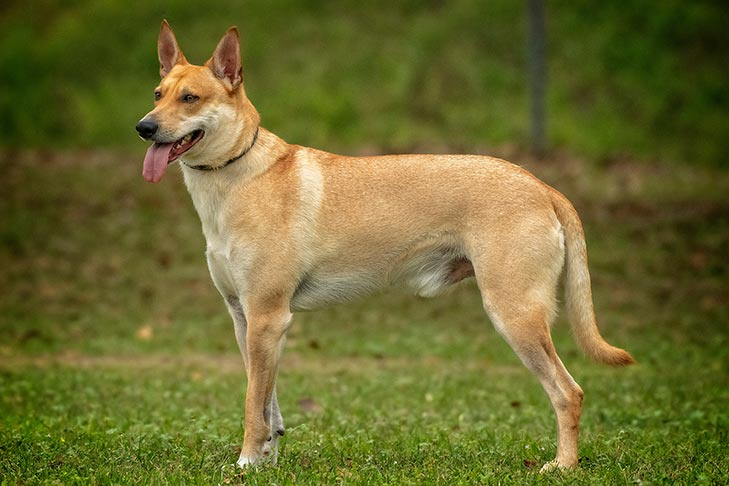

In [37]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [38]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [39]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [40]:
type(response2[0][0])

float

In [41]:
response2[0]

[-2.6200966835021973,
 -1.7839187383651733,
 -0.4178096652030945,
 -0.10426720976829529,
 -1.8988728523254395,
 -0.933385968208313,
 0.11574618518352509,
 0.2227245569229126,
 -2.6947293281555176,
 -0.9397773742675781,
 -0.07906225323677063,
 -2.775785207748413,
 -1.8236974477767944,
 0.16907787322998047,
 -0.30387765169143677,
 0.22626635432243347,
 -2.5950417518615723,
 -1.090857982635498,
 -0.2849547266960144,
 0.37625932693481445,
 -3.3860466480255127,
 -3.8015332221984863,
 -2.0609374046325684,
 -0.34431833028793335,
 -0.7686353921890259,
 -2.340825319290161,
 -1.4663516283035278,
 -1.2728859186172485,
 -2.6480000019073486,
 -1.4626139402389526,
 -0.24683457612991333,
 0.49775874614715576,
 -2.9164586067199707,
 0.5274293422698975,
 -2.2854857444763184,
 -2.252896785736084,
 -0.2293662428855896,
 -2.7789041996002197,
 0.3206307291984558,
 0.31204500794410706,
 0.5477383732795715,
 -1.0781968832015991,
 0.10801893472671509,
 -0.22434665262699127,
 -0.3700046241283417,
 -2.564198970

In [42]:
import torch
import numpy as np
np.argmax(response, 1)

array([40])